In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import fastai
from fastai.tabular import *
from fastai.callbacks import SaveModelCallback

In [2]:
DATA_PATH = '../data/'
PATH = '../tmp'

In [3]:
import os
files = os.listdir(DATA_PATH)
files = [f for f in files if f.find('.csv') != -1]
files

['scalar_coupling_contributions.csv',
 'mulliken_charges.csv',
 'structures.csv',
 'test.csv',
 'train.csv',
 'magnetic_shielding_tensors.csv',
 'dipole_moments.csv',
 'sample_submission.csv',
 'potential_energy.csv']

In [4]:
train_df = pd.read_csv(DATA_PATH+'train.csv')
test_df = pd.read_csv(DATA_PATH+'test.csv')
structures_df = pd.read_csv(DATA_PATH+'structures.csv')
scc_df = pd.read_csv(DATA_PATH+'scalar_coupling_contributions.csv')
mc_df = pd.read_csv(DATA_PATH+'mulliken_charges.csv')
mst_df = pd.read_csv(DATA_PATH+'magnetic_shielding_tensors.csv')
dm_df = pd.read_csv(DATA_PATH+'dipole_moments.csv')
pe_df = pd.read_csv(DATA_PATH+'potential_energy.csv')

In [5]:
train_df.shape, test_df.shape, structures_df.shape, scc_df.shape, mc_df.shape, mst_df.shape, dm_df.shape, pe_df.shape

((4658147, 6),
 (2505542, 5),
 (2358657, 6),
 (4658147, 8),
 (1533537, 3),
 (1533537, 11),
 (85003, 4),
 (85003, 2))

In [6]:
def group_mean_log_mae(y_true, y_pred, types, return_groups=False):
    maes = (y_true - y_pred).abs().groupby(types).mean()
    if return_groups:
        return np.log(maes).mean(), np.log(maes)
    else:
        return np.log(maes).mean()

In [12]:
train_df['scalar_coupling_constant'].head(), scc_df.iloc[:,-4:].sum(1).head()

(0    84.8076
 1   -11.2570
 2   -11.2548
 3   -11.2543
 4    84.8074
 Name: scalar_coupling_constant, dtype: float64, 0    84.807609
 1   -11.256932
 2   -11.254906
 3   -11.254346
 4    84.807408
 dtype: float64)

In [11]:
group_mean_log_mae(train_df['scalar_coupling_constant'], scc_df.iloc[:,-4:].sum(1), train_df['type'], True)

(-11.567337637674102, type
 1JHC    -9.126157
 1JHN   -10.309901
 2JHC   -12.548109
 2JHH   -10.577209
 2JHN   -12.278825
 3JHC   -12.467633
 3JHH   -11.771978
 3JHN   -13.458889
 dtype: float64)

In [6]:
train_df.head(40)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.80760
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.25700
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.25480
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.25430
4,4,dsgdb9nsd_000001,2,0,1JHC,84.80740
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.25410
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.25480
7,7,dsgdb9nsd_000001,3,0,1JHC,84.80930
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.25430
9,9,dsgdb9nsd_000001,4,0,1JHC,84.80950


/anaconda2/envs/python36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


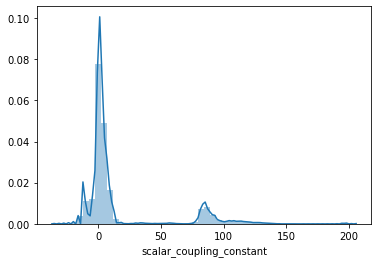

In [7]:
sns.distplot(train_df['scalar_coupling_constant'])

CPU times: user 6.39 s, sys: 71.7 ms, total: 6.46 s
Wall time: 1.3 s


/anaconda2/envs/python36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


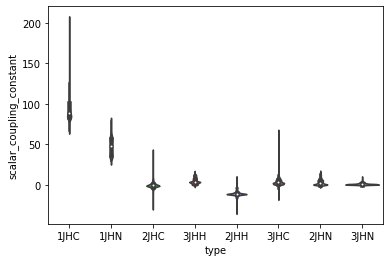

In [8]:
%%time
sns.violinplot(x='type', y='scalar_coupling_constant', data=train_df[::10])

In [9]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures_df, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [10]:
%%time
train_df = map_atom_info(train_df, 0)
train_df = map_atom_info(train_df, 1)
test_df = map_atom_info(test_df, 0)
test_df = map_atom_info(test_df, 1)

CPU times: user 30.8 s, sys: 6.8 s, total: 37.6 s
Wall time: 12.5 s


In [11]:
train_p_0 = train_df[['x_0', 'y_0', 'z_0']].values
train_p_1 = train_df[['x_1', 'y_1', 'z_1']].values
test_p_0 = test_df[['x_0', 'y_0', 'z_0']].values
test_p_1 = test_df[['x_1', 'y_1', 'z_1']].values

In [12]:
%%time
train_df['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test_df['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

CPU times: user 698 ms, sys: 224 ms, total: 921 ms
Wall time: 161 ms


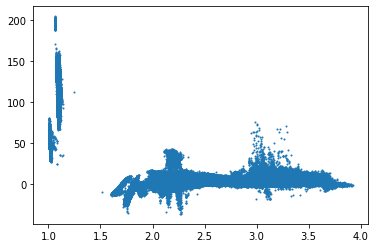

In [13]:
plt.scatter(train_df['dist'], train_df['scalar_coupling_constant'], s=1)

In [14]:
def plot_dist_per_type(df, var):
    axes_index = 0
    fig, axes = plt.subplots(8, 1, figsize=(20, 20), sharey=False, sharex=True)
    for i, (mtype, d) in enumerate(df.groupby('type')):
        d[var].plot(kind='hist',
                    bins=100,
                    title='Distribution of Distance Feature for {}'.format(mtype),
                    color=f'C{i}',
                    ax=axes[axes_index])
        axes_index += 1
    plt.show()

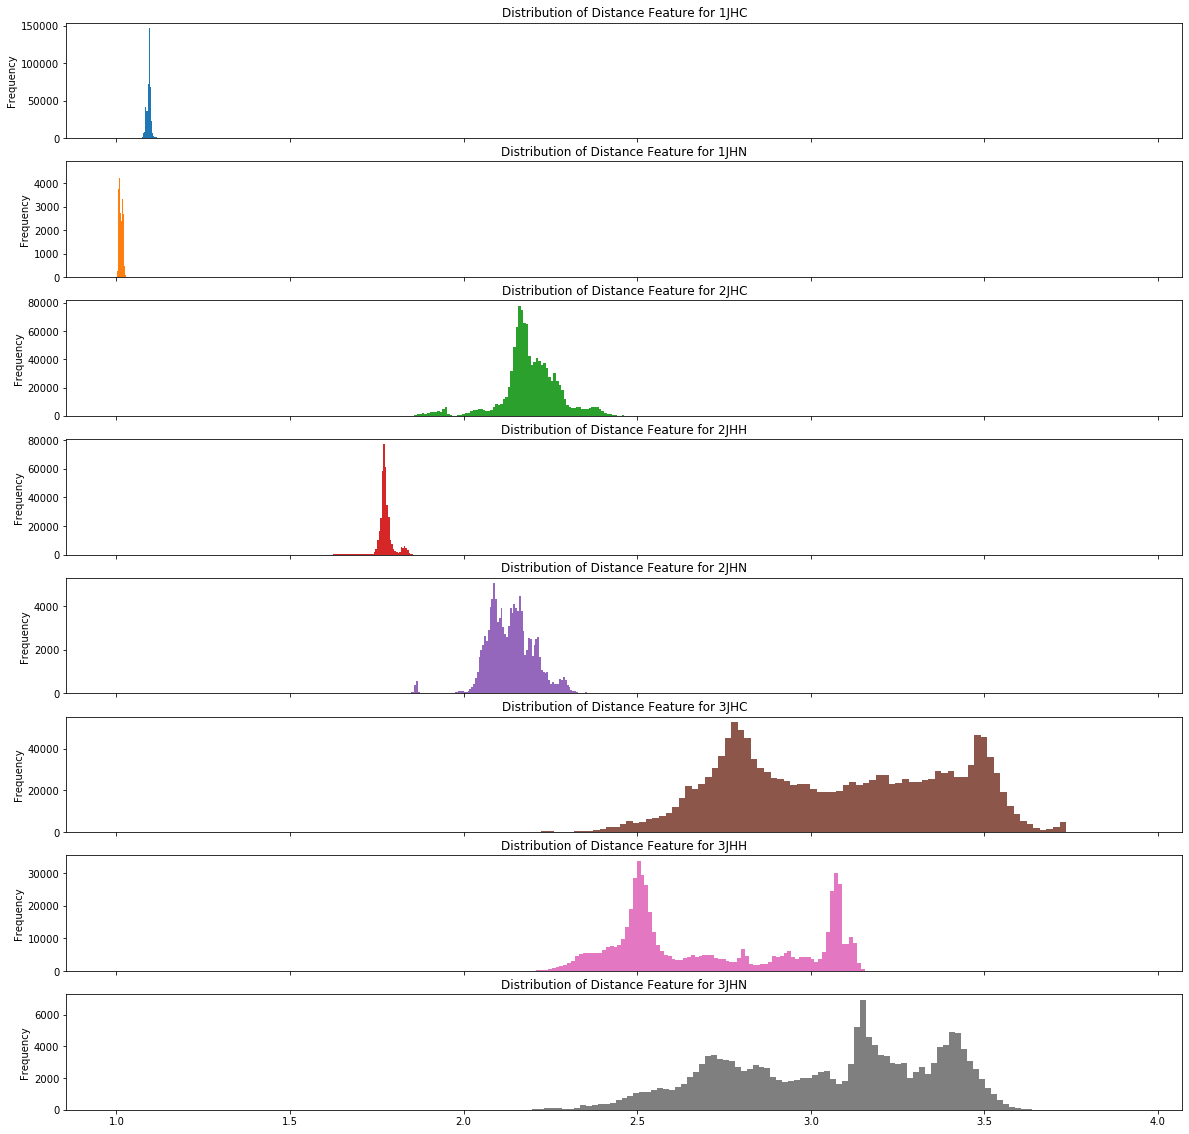

In [15]:
plot_dist_per_type(train_df, 'dist')

In [16]:
%%time
train_df['dist_to_type_mean'] = train_df['dist'] / train_df.groupby('type')['dist'].transform('mean')
test_df['dist_to_type_mean'] = test_df['dist'] / test_df.groupby('type')['dist'].transform('mean')

CPU times: user 1.53 s, sys: 599 ms, total: 2.13 s
Wall time: 510 ms


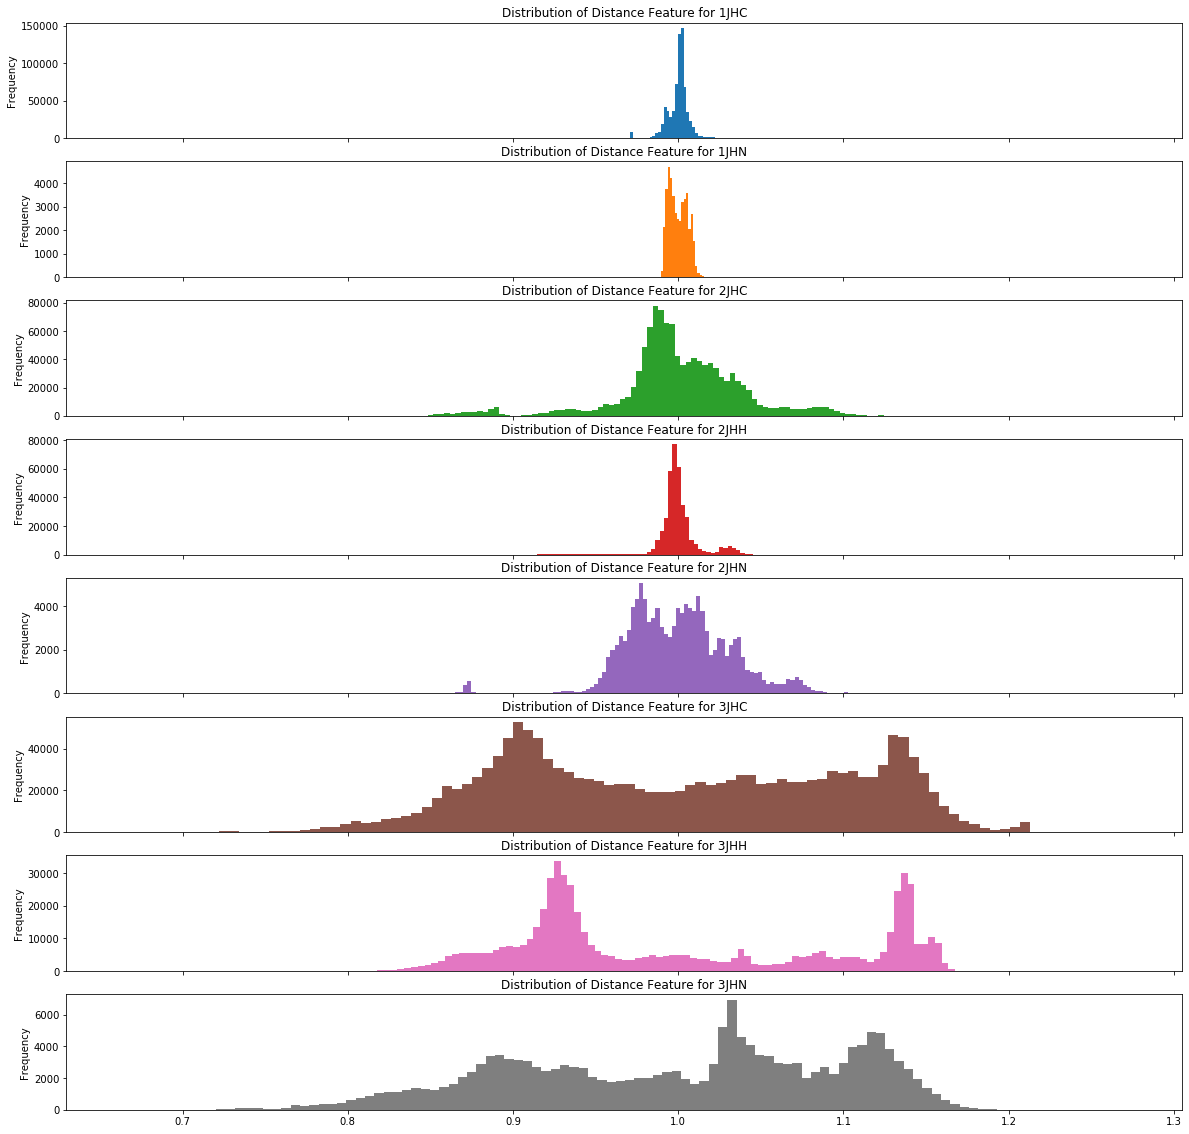

In [17]:
plot_dist_per_type(train_df, 'dist_to_type_mean')

In [18]:
%%time
atoms_per_molecule_df = structures_df.groupby(['molecule_name', 'atom']).count()
atoms_per_molecule_map = atoms_per_molecule_df['atom_index'].unstack().fillna(0).astype(int).to_dict()

CPU times: user 1.59 s, sys: 352 ms, total: 1.94 s
Wall time: 807 ms


In [19]:
%%time
pd.options.mode.chained_assignment = None
atoms = structures_df['atom'].unique()
train_df['num_atoms'] = 0
test_df['num_atoms'] = 0
for atom in atoms:
    train_df[f'num_{atom}_atoms'] = train_df['molecule_name'].map(atoms_per_molecule_map[atom])
    train_df['num_atoms'] += train_df[f'num_{atom}_atoms']
    test_df[f'num_{atom}_atoms'] = test_df['molecule_name'].map(atoms_per_molecule_map[atom])
    test_df['num_atoms'] += test_df[f'num_{atom}_atoms']

CPU times: user 13.2 s, sys: 2.61 s, total: 15.8 s
Wall time: 5.5 s


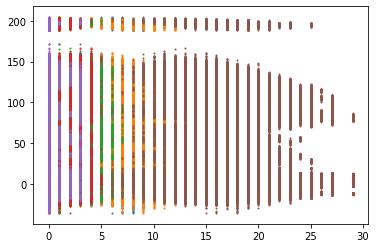

In [20]:
for i, atom in enumerate(structures_df['atom'].unique()):
    plt.scatter(train_df[f'num_{atom}_atoms'], train_df['scalar_coupling_constant'], c=f'C{i}', s=1)
plt.scatter(train_df['num_atoms'], train_df['scalar_coupling_constant'], c=f'C{i+1}', s=1)

In [21]:
from IPython.display import display
with pd.option_context("display.max_columns", 100):
    display(train_df.head())

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_to_type_mean,num_atoms,num_C_atoms,num_H_atoms,num_N_atoms,num_O_atoms,num_F_atoms
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,0.999134,5,1,4,0,0,0
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,1.004634,5,1,4,0,0,0
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147,1.004649,5,1,4,0,0,0
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157,1.004655,5,1,4,0,0,0
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,0.999133,5,1,4,0,0,0


In [22]:
structures_df.head(40)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602


In [23]:
scc_df.head(20)

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.02240,0.254579,1.258620,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.03470,0.352978,2.858390,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.03250,0.352944,2.858520,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.03190,0.352934,2.858550,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.02220,0.254585,1.258610,0.272013
5,dsgdb9nsd_000001,2,3,2JHH,-11.03170,0.352932,2.858560,-3.433950
6,dsgdb9nsd_000001,2,4,2JHH,-11.03240,0.352943,2.858530,-3.433870
7,dsgdb9nsd_000001,3,0,1JHC,83.02410,0.254634,1.258560,0.272012
8,dsgdb9nsd_000001,3,4,2JHH,-11.03190,0.352943,2.858560,-3.433930
9,dsgdb9nsd_000001,4,0,1JHC,83.02430,0.254628,1.258560,0.272012


In [24]:
mc_df.head(20)

,molecule_name,atom_index,mulliken_charge
0,dsgdb9nsd_000001,0,-0.535689
1,dsgdb9nsd_000001,1,0.133921
2,dsgdb9nsd_000001,2,0.133922
3,dsgdb9nsd_000001,3,0.133923
4,dsgdb9nsd_000001,4,0.133923
5,dsgdb9nsd_000002,0,-0.707143
6,dsgdb9nsd_000002,1,0.235712
7,dsgdb9nsd_000002,2,0.235712
8,dsgdb9nsd_000002,3,0.235720
9,dsgdb9nsd_000003,0,-0.589706


In [25]:
mst_df.head(20)

,molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
0,dsgdb9nsd_000001,0,195.3150,0.0000,-0.0001,0.0000,195.3170,0.0007,-0.0001,0.0007,195.3170
1,dsgdb9nsd_000001,1,31.3410,-1.2317,4.0544,-1.2317,28.9546,-1.7173,4.0546,-1.7173,34.0861
2,dsgdb9nsd_000001,2,31.5814,1.2173,-4.1474,1.2173,28.9036,-1.6036,-4.1476,-1.6036,33.8967
3,dsgdb9nsd_000001,3,31.5172,4.1086,1.2723,4.1088,33.9068,1.6950,1.2724,1.6951,28.9579
4,dsgdb9nsd_000001,4,31.4029,-4.0942,-1.1793,-4.0944,34.0776,1.6259,-1.1795,1.6260,28.9013
5,dsgdb9nsd_000002,0,275.6350,0.0003,0.0133,0.0003,275.6360,-0.0003,0.0161,-0.0004,237.4970
6,dsgdb9nsd_000002,1,31.2593,5.6126,-2.1025,5.6136,37.4364,-3.5567,-2.4461,-4.1372,27.9884
7,dsgdb9nsd_000002,2,31.0341,-5.4827,-2.0299,-5.4837,37.6618,3.5987,-2.3616,4.1861,27.9885
8,dsgdb9nsd_000002,3,40.7507,-0.1300,4.1318,-0.1300,27.9413,-0.0419,4.8083,-0.0488,27.9889
9,dsgdb9nsd_000003,0,310.0960,0.0000,0.0000,0.0000,355.7730,0.0000,0.0000,0.0000,324.1550


In [26]:
dm_df.head(20)

,molecule_name,X,Y,Z
0,dsgdb9nsd_000001,0.0000,0.0000,0.0000
1,dsgdb9nsd_000002,-0.0002,0.0000,1.6256
2,dsgdb9nsd_000003,0.0000,0.0000,-1.8511
3,dsgdb9nsd_000005,0.0000,0.0000,-2.8937
4,dsgdb9nsd_000007,0.0000,0.0000,0.0000
5,dsgdb9nsd_000008,0.6506,-1.3801,-0.0002
6,dsgdb9nsd_000009,0.7156,0.0004,-0.0004
7,dsgdb9nsd_000010,3.8266,0.0000,-0.0001
8,dsgdb9nsd_000011,2.3605,1.0119,0.0004
9,dsgdb9nsd_000012,-3.6612,0.7058,0.0009


In [27]:
pe_df.head(20)

,molecule_name,potential_energy
0,dsgdb9nsd_000001,-40.52368
1,dsgdb9nsd_000002,-56.56025
2,dsgdb9nsd_000003,-76.42608
3,dsgdb9nsd_000005,-93.42849
4,dsgdb9nsd_000007,-79.83869
5,dsgdb9nsd_000008,-115.73030
6,dsgdb9nsd_000009,-116.66500
7,dsgdb9nsd_000010,-132.76340
8,dsgdb9nsd_000011,-153.84300
9,dsgdb9nsd_000012,-169.90610


In [28]:
'Set2SetGRU'[:7]

'Set2Set'